In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from evallm.experiments.transducer_summary import (
    for_model_and_prompt as for_model_t,
    compute_model_results as compute_model_results_t,
    compute_deterministic_baseline_outcomes as dbo_t,
)

from evallm.experiments.sequence_completion_summary import (
    for_model as for_model_sc,
    current_setting as current_setting_s,
    results_for_baseline as rfb_s,
)
from evallm.experiments.sequence_completion.sequence_completion_prompt import (
    WithTemperatureSequenceCompletionPrompt,
)
from evallm.prompting.transducer_prompt import WithTemperatureTransducerPrompter

from evallm.experiments.transducer_plotting import (
    setup_plot,
)

from evallm.experiments.results_by_difficulty.plotting import THEME_COLORS

In [3]:
count = 1000

In [4]:
def produce_transducer_results(**kwargs):
    r = for_model_t(
        "mistral-nemo-minitron-8B",
        count,
        "Basic",
        **kwargs,
    )

    baselines = {
        mod: {prompt: np.mean(v) for prompt, v in by_prompt.items()}
        for mod, by_prompt in dbo_t(
            **kwargs,
            include_brute_force=False,
            include_null=False,
            min_gram=4,
            max_gram=7,
            include_infinity_gram=True,
        ).items()
    }

    models = {
        mod: {prompt: np.mean(res) for prompt, res in prompts_res.items()}
        for mod, prompts_res in compute_model_results_t(
            r, accuracy_summary=True
        ).items()
    }

    overall = {**baselines, **models}
    return {k: v["Basic"] for k, v in overall.items()}


def plot_results(results, title):
    setup_plot()
    for i, k in enumerate(results):
        plt.plot(
            results.index,
            100 * results[k],
            label=k,
            color="black" if "Gram" not in k else THEME_COLORS[:-1][i],
        )
    plt.legend()
    plt.xscale("log")
    plt.xticks(nss_vals, nss_vals)
    plt.xlabel("Number examples [log scale]")
    plt.ylabel(r"Accuracy [\%]")
    plt.title(title)
    plt.grid()
    # plt.ylim(85, 100)
    plt.show()

In [5]:
nss_vals = [30, 60, 150, 300, 600]

transducer_results = pd.DataFrame(
    [produce_transducer_results(num_sequence_symbols=nss) for nss in nss_vals],
    index=nss_vals,
)

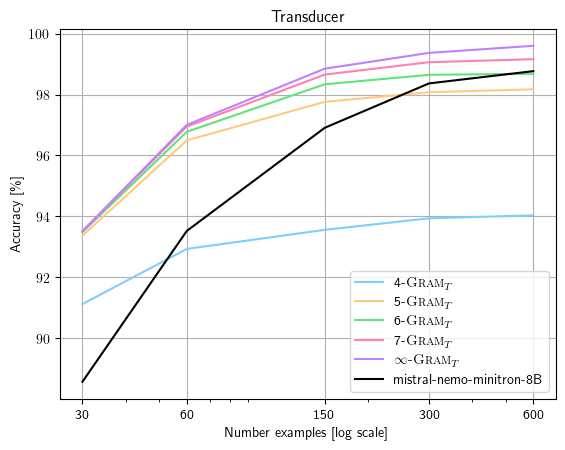

In [6]:
plot_results(transducer_results, "Transducer")

In [7]:
def produce_sc_results(num_sequences):
    setting = {**current_setting_s, "num_sequences": num_sequences}
    r = for_model_sc(
        "mistral-nemo-minitron-8B",
        count,
        "Basic",
        na_mode="ignore",
        setting=setting,
    )
    r.update(rfb_s(setting, include_non_ngram=False, min_ngram=4))
    results = defaultdict(dict)
    for mod, prompt in r:
        assert prompt == "Basic"
        results[mod] = np.mean(r[mod, prompt])
    return results

In [8]:
sc_results = pd.DataFrame(
    [produce_sc_results(nss) for nss in nss_vals],
    index=nss_vals,
)

In [9]:
sc_results

,mistral-nemo-minitron-8B,4-\textsc{Gram}$_S$,5-\textsc{Gram}$_S$,6-\textsc{Gram}$_S$
30,0.787033,0.896267,0.911667,0.917100
60,0.821167,0.894000,0.912233,0.924500
150,0.851667,0.892133,0.913300,0.931667
300,0.867433,0.893633,0.912200,0.931133
600,0.886800,0.896000,0.911767,0.922633


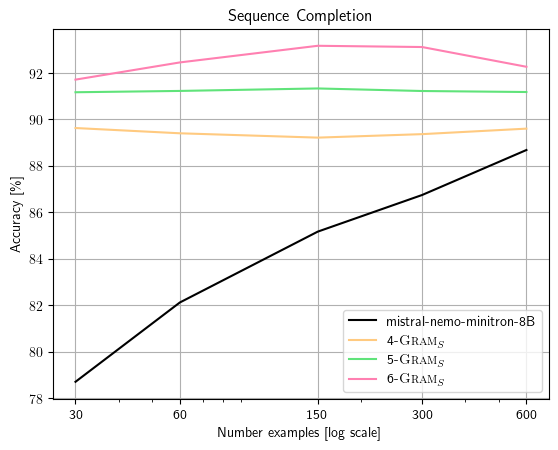

In [10]:
plot_results(sc_results, "Sequence Completion")